In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer

In [130]:
#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
data = pd.read_csv('/content/drive/MyDrive/ start/OTT Content Reviews.xlsx - Sheet1 (3).csv', encoding='UTF-8')

data

,Text,Label
0,"পুরাই অস্থির!!! ""সাকিল, চট্টগ্রাম",1
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ছিল ওনার জন্য ক...,1
2,পুরাই আগুন অনেক দিনের অপেক্ষায় আছি এই কাজ টা দ...,1
3,"ইন্টারেস্টিং স্টোরি,অভিনয়, সিনেমেটোগ্রাফিও জোস",1
4,এট লিস্ট অনন্ত জলীল এর ১০০ কোটি টাকার মুভির ট্...,1
...,...,...
6695,"অযথা সময় নষ্ট,এটা কোনো নাটক",2
6696,একটুকুও ভাল লাগেনাই,2
6697,এসব নষ্টা নাটক দেখে মানুষের চরিত্র খারাপ হয়,2
6698,টিপু ওয়ালা আপু মনোজ এর জন‍্য একটা সুন্দরী একটা...,2


In [133]:
data.drop_duplicates(inplace=True)

In [134]:
#data.dropna(inplace=True)

In [135]:
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Label ==1]),
      "\nTotal Negative Reviews:",len(data[data.Label==2]),
      "\nTotal Neutral Reviews:",len(data[data.Label ==0]))


Total Reviews: 6334 
Total Positive Reviews: 3407 
Total Negative Reviews: 2082 
Total Neutral Reviews: 845


In [136]:
data.columns

Index(['Text', 'Label'], dtype='object')

In [137]:
# print some unprocessed reviews
sample_data = [10,100,150,222,250,600,650,666,689,640,650,700,750,800,1000]
for i in sample_data:
      print(data.Text[i],'\n','Sentiment:-- ',data.Label[i],'\n')

আগুন লাগিয়ে দিলো এক ঝলকেই 
 Sentiment:--  0 

পুড়াই আগুন 
 Sentiment:--  1 

চঞ্চল চৌধুরী এবং সালাউদ্দিন লাভলু ধামাকা কিছু হবে অপেক্ষায় রইলাম ️️️ 
 Sentiment:--  1 

বাপরে বাপ! আগুন। দেখতে হবে। Another masterpiece will coming soon.. 
 Sentiment:--  1 

আমার কি প্রেম হবে না ১৮ বছর ধরে আমি সিঙ্গেল😞😞😞 
 Sentiment:--  0 

বাপরে আসলেই শ্বাসরুদ্ধকর ছিলো।এইটুকু দেখেই বোকের ভেতর ধড়পড় করছে জানিনা মুভিটা আরো কতোটা ভয়ংকর হবে।এই রকম মুভি আমার মতো দূর্বল চিত্তের মানুষের দেখা উচিত না। 
 Sentiment:--  1 

গল্প গুলা সুন্দর ছিল। বাংলায় এমন আরো অন্থরোলজি বানানো দরকার। 
 Sentiment:--  1 

পরিমনির কি চমৎকার আর সাবলীল অভিনয়। অভিনন্দন পরিমনি 
 Sentiment:--  1 

শ্যামল মাওলার কেনো ভয়েজ চেঞ্জ করা হয়েছে? 
 Sentiment:--  2 

শুরুতেই interest তৈরি হয়ে গেছে। 
 Sentiment:--  1 

গল্প গুলা সুন্দর ছিল। বাংলায় এমন আরো অন্থরোলজি বানানো দরকার। 
 Sentiment:--  1 

গল্পটা দারুন ছিল 
 Sentiment:--  1 

সর্বোচ্চ পর্যায়ের অভিনয় হয়েছে,,, ২০৭০ সালের জন্য রেখে গেলাম 
 Sentiment:--  1 

এই রকম কিছু দেখলে মনে হয়..যে দেশের মিড

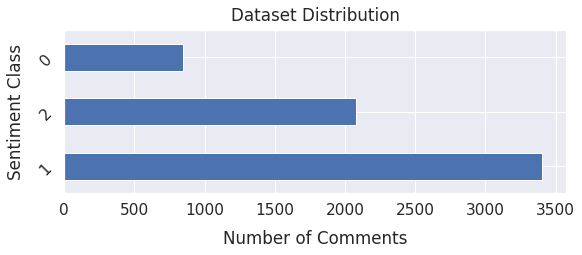

In [138]:
sns.set(font_scale=1.4)
data['Label'].value_counts().plot(kind='barh', figsize=(9, 3))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [139]:
!pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [140]:
!pip install bangla-stemmer
#importing stemmer
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bangla_stemmer.stemmer import stemmer
import re
btokenizer = BasicTokenizer()

def clean_text(text):
    text = re.sub('[^\u0980-\u09FF]',' ',str(text))
    tokens = btokenizer.tokenize(text)
    stmr = stemmer.BanglaStemmer()
    stm = stmr.stem(tokens)
    filtered = []
    for i in stm:
      
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
       
        filtered.append(i)
    
    return " ".join(filtered)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
data['cleaned'] = data.Text.apply(clean_text)

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied fourth rules..
a

In [142]:
# Apply the function into the dataframe
data['cleaned'] = data['Text'].apply(clean_text)  

# print some cleaned reviews from the dataset
sample_data = [10,100,25,854,966,1500,1589,1700,2000,2500,4000,4500]
for i in sample_data:
     print('Original:\n',data.Text[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Label[i],'\n')

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied third rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied first rules..
applied third rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied second rules..
applied first rules..
ap

In [143]:
data

,Text,Label,cleaned
0,"পুরাই অস্থির!!! ""সাকিল, চট্টগ্রাম",1,পুরা অস্থির সাকিল চট্টগ্রাম
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ছিল ওনার জন্য ক...,1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ওন কান্না আস
2,পুরাই আগুন অনেক দিনের অপেক্ষায় আছি এই কাজ টা দ...,1,পুরা আগুন অপেক্ষায় আছি টা দেখ
3,"ইন্টারেস্টিং স্টোরি,অভিনয়, সিনেমেটোগ্রাফিও জোস",1,ইন্টারেস্টিং স্টোরি অভিনয় সিনেমেটোগ্রাফি জোস
4,এট লিস্ট অনন্ত জলীল এর ১০০ কোটি টাকার মুভির ট্...,1,এট লিস্ট অনন্ত জলীল ১০০ টাকা মুভির ট্রেইল থেক ...
...,...,...,...
6692,আচ্ছা এই নাটকের পরিচালক কে? রে? এইসব রাস্তার ট...,2,আচ্ছা নাটক পরিচালক রে এইসব রাস্ত টোকা খাংকির প...
6693,টিপ পরে অভিনয় কর বেডা ।,2,টিপ অভিনয় কর বেডা
6694,নপুংসক মনোজ তোর কপালে টিপ কই?,2,নপুংসক মনোজ তোর কপালে টিপ কই
6695,"অযথা সময় নষ্ট,এটা কোনো নাটক",2,অযথা সময় নষ্ট নাটক


In [144]:
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))

# Remove the reviews with least words
dataset = data.loc[data.length>2]
dataset = data.reset_index(drop = True)

In [145]:
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset))

After Cleaning: 
Removed 0 Small Reviews 
Total Reviews: 6334


In [146]:
print("Maximum Length of a Review:",max(dataset.length))
print("Minimum Length of a Review:", min(dataset.length))
print("Average Length of a Review:",round(np.mean(dataset.length),0))

Maximum Length of a Review: 156
Minimum Length of a Review: 0
Average Length of a Review: 8.0


In [147]:
dataset=dataset[['cleaned','Label']]
dataset.head(5)

,cleaned,Label
0,পুরা অস্থির সাকিল চট্টগ্রাম,1
1,নাজিফা তুষি আপু অবিনয় টা বেস্ট ওন কান্না আস,1
2,পুরা আগুন অপেক্ষায় আছি টা দেখ,1
3,ইন্টারেস্টিং স্টোরি অভিনয় সিনেমেটোগ্রাফি জোস,1
4,এট লিস্ট অনন্ত জলীল ১০০ টাকা মুভির ট্রেইল থেক ...,1


In [148]:
#Dataset Summary

def data_summary(dataset):
    
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
                
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        
        # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].cleaned)))
        
        # Total Word per class
        words.append(len(word_list))
        
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
                
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label


documents,words,u_words,class_names = data_summary(dataset)   


Class Name :  1
Number of Documents:3407
Number of Words:26704
Number of Unique Words:5167
Most Frequent Words:

গান	732
ভালো	647
এক	592
অসাধারণ	529
সুন্দর	374
কর	332
অভিনয়	300
নাটক	284
আম	282
দেখ	271

Class Name :  2
Number of Documents:2082
Number of Words:17575
Number of Unique Words:5173
Most Frequent Words:

কর	381
ভালো	240
এক	230
নাটক	159
দেখ	122
এসব	120
দাখ	118
সিরিজ	116
আম	114
থেক	114

Class Name :  0
Number of Documents:845
Number of Words:5210
Number of Unique Words:1972
Most Frequent Words:

কর	96
দেখ	70
টা	68
মুভি	68
ভাই	63
আম	60
এক	53
নাটক	52
এপিসোড	44
চাই	43
Total Number of Unique Words:9117


In [149]:
#dataset['abel']=dataset['label'].replace({'positive':1,'negative':0,'neutral':2})
#dataset.head()

In [150]:
#Labels=dataset.Label
#Labels

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf1 = TfidfVectorizer(ngram_range=(1,1),use_idf=True,tokenizer=lambda x: x.split()) 
X = tfidf1.fit_transform(dataset['cleaned'])
y=dataset['Label']
print("Shape of TF-IDF:",X.shape,'\n')

Shape of TF-IDF: (6334, 9117) 



In [152]:
y

0       1
1       1
2       1
3       1
4       1
       ..
6329    2
6330    2
6331    2
6332    2
6333    2
Name: Label, Length: 6334, dtype: int64

In [153]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [154]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

Class=1, n=3407 (33.333%)
Class=0, n=3407 (33.333%)
Class=2, n=3407 (33.333%)


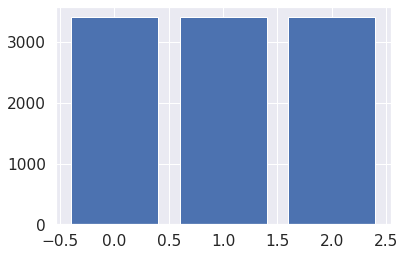

In [155]:
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [156]:
review='পুরাই অস্থির সাকিল চট্টগ্রাম	'
print("Sample Review: ",review)
vector = tfidf1.transform([review])
df = pd.DataFrame(vector.T.todense(), index=tfidf1.get_feature_names(), columns=["tfidf"])
a = df.sort_values(by=["tfidf"],ascending=False)
print(a[0:len(review.split())])

Sample Review:  পুরাই অস্থির সাকিল চট্টগ্রাম	
              tfidf
সাকিল      0.632575
চট্টগ্রাম  0.577506
অস্থির     0.516077
বিহারি     0.000000


In [157]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size = 0.8, test_size = 0.2,random_state =100)

print('Shape of X_train:', xtrain.shape)
print('Shape of X_test:', xtest.shape)
print('Shape of Y_train:', ytrain.shape)
print('Shape of Y_test:', ytest.shape)

Shape of X_train: (8176, 9117)
Shape of X_test: (2045, 9117)
Shape of Y_train: (8176,)
Shape of Y_test: (2045,)


In [158]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [159]:
mn= MultinomialNB()
mn.fit(xtrain, ytrain)
prediction = mn.predict(xtest)
pred_prob1 = mn.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 83.96%


In [160]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       691
           1       0.79      0.84      0.82       653
           2       0.90      0.78      0.84       701

    accuracy                           0.84      2045
   macro avg       0.84      0.84      0.84      2045
weighted avg       0.84      0.84      0.84      2045



In [161]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

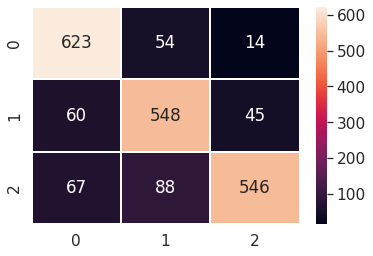

In [162]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [163]:
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

In [164]:
fpr = {}
tpr = {}
thresh ={}
n_class = 3

In [165]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob1[:,i], pos_label=i)

In [166]:
pred_prob1 = mn.predict_proba(xtest)[:,1]

In [167]:
fpr1 , tpr1, thresholds1 =metrics.roc_curve(ytest, pred_prob1,pos_label=1)

In [168]:
knn= KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
knn.fit(xtrain, ytrain)
prediction = knn.predict(xtest)
pred_prob2 = knn.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 68.80%


In [169]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.71      0.92      0.81       691
           1       0.97      0.21      0.35       653
           2       0.63      0.90      0.74       701

    accuracy                           0.69      2045
   macro avg       0.77      0.68      0.63      2045
weighted avg       0.77      0.69      0.64      2045



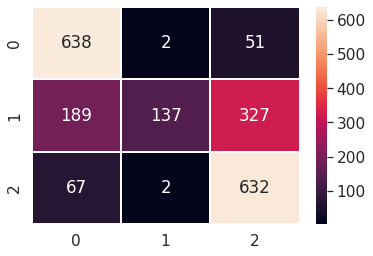

In [170]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [171]:
pred_prob2 = knn.predict_proba(xtest)[:,1]
fpr2 , tpr2, thresholds2 =metrics.roc_curve(ytest, pred_prob2,pos_label=1)

In [172]:
lsvm= SVC(kernel="linear", probability=True)
lsvm.fit(xtrain, ytrain)
prediction = lsvm.predict(xtest)
pred_prob3 = lsvm.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 84.65%


In [173]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       691
           1       0.89      0.76      0.82       653
           2       0.79      0.90      0.84       701

    accuracy                           0.85      2045
   macro avg       0.85      0.84      0.85      2045
weighted avg       0.85      0.85      0.85      2045



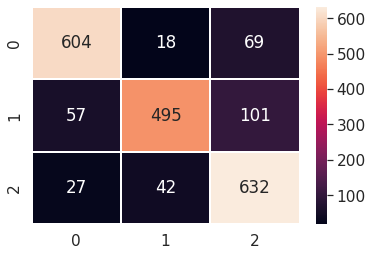

In [174]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [175]:
pred_prob3 = mn.predict_proba(xtest)[:,1]
fpr3 , tpr3, thresholds3 =metrics.roc_curve(ytest, pred_prob3,pos_label=1)

In [176]:
ksvm= SVC(kernel = 'rbf',probability=True)
ksvm.fit(xtrain, ytrain)
prediction = ksvm.predict(xtest)
pred_prob4 = ksvm.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 88.36%


In [177]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       691
           1       0.84      0.90      0.87       653
           2       0.86      0.88      0.87       701

    accuracy                           0.88      2045
   macro avg       0.89      0.88      0.88      2045
weighted avg       0.89      0.88      0.88      2045



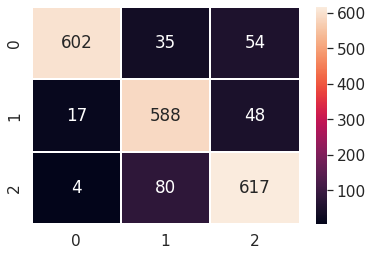

In [178]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [179]:
pred_prob4 = ksvm.predict_proba(xtest)[:,1]
fpr4 , tpr4, thresholds4 =metrics.roc_curve(ytest, pred_prob4,pos_label=1)

In [180]:
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
prediction = dt.predict(xtest)
pred_prob5 = dt.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))

Accuracy: 78.92%


In [181]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       691
           1       0.79      0.75      0.77       653
           2       0.74      0.78      0.76       701

    accuracy                           0.79      2045
   macro avg       0.79      0.79      0.79      2045
weighted avg       0.79      0.79      0.79      2045



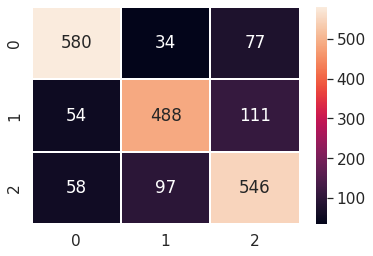

In [182]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [183]:
pred_prob5 = dt.predict_proba(xtest)[:,1]
fpr5 , tpr5, thresholds5 =metrics.roc_curve(ytest, pred_prob5,pos_label=1)

In [184]:
rf = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
rf.fit(xtrain, ytrain)
prediction = rf.predict(xtest)
pred_prob6 = rf.predict_proba(xtest)
print("Accuracy: {0:.2%}".format(accuracy_score(prediction, ytest)))


Accuracy: 85.53%


In [185]:
print('\nClassification Report\n')
print(classification_report(ytest, prediction))


Classification Report

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       691
           1       0.87      0.78      0.82       653
           2       0.81      0.87      0.84       701

    accuracy                           0.86      2045
   macro avg       0.86      0.85      0.85      2045
weighted avg       0.86      0.86      0.85      2045



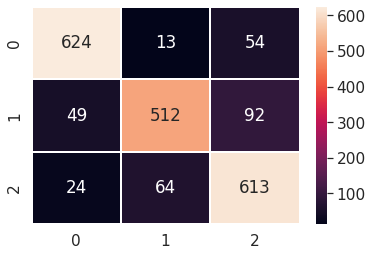

In [186]:
conf_m = confusion_matrix(ytest, prediction)
sns.heatmap(conf_m, linewidths=1, annot=True, fmt='g')

In [187]:
pred_prob6 = rf.predict_proba(xtest)[:,1]
fpr6 , tpr6, thresholds6 =metrics.roc_curve(ytest, pred_prob6,pos_label=1)

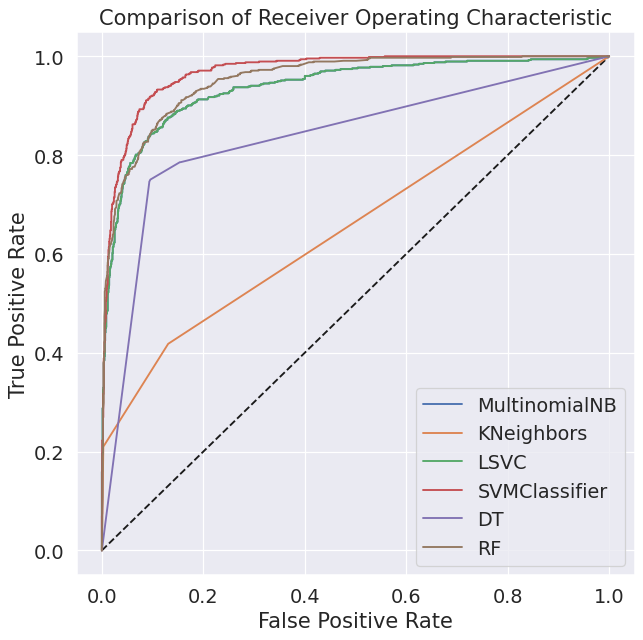

In [188]:
plt.figure(figsize=(8, 8), dpi=90)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "MultinomialNB" )
plt.plot(fpr2, tpr2, label= "KNeighbors" )
plt.plot(fpr3, tpr3, label= "LSVC" )
plt.plot(fpr4, tpr4, label= "SVMClassifier")
plt.plot(fpr5, tpr5, label= "DT")
plt.plot(fpr6, tpr6, label= "RF")


plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Comparison of Receiver Operating Characteristic')
plt.show()